In [144]:
import panel as pn
import pandas as pd 
import numpy as np 
import hvplot


In [31]:
df = pd.read_csv("/home/volkan/Desktop/PY/TRY/Automobile_data.csv")

In [189]:
year = pn.widgets.IntRangeSlider(name="year",width=500,start= 61, end=326,value=(61,326), value_throttled=(61,326))

@pn.depends(year.param.value_throttled)
def year_range(year):
    return ("Floods Between:{start} —  {end}".format(start=year[0], end=year[1]))

In [ ]:
#KPI- ENGİNE SİZE

In [211]:

@pn.depends(year.param.value_throttled)
def dead_stat(year):
    return  "Average Price {}".format(df[df["engine.size"].between(year[0],year[1])]["price"].sum())
        
pn.Row(dead_stat)

Row
    [0] ParamFunction(function)

In [200]:
# Bar chart
@pn.depends(year.param.value_throttled)
def plot_bar(year):
    years_df = df[df["engine.size"].year.between(year[0],year[1])]
    bar_table = years_df["make"].value_counts().reset_index().rename(columns={"index":"cause", "make":"brands"})
    return bar_table[:10].sort_values("brands").hvplot.barh("cause", "brands", 
       invert=False, legend="bottom_right", height=600)
# # Map
# @pn.depends(year.param.value_throttled)
# def plot_map(year):
#     years_df = df[df["engine.size"].between(year[0],year[1])]
#     return df.hvplot.points('horsepower', 'city.mpg', xaxis=None, yaxis=None, geo=True, color='red', alpha=0.5, tiles='CartoLight', hover_cols=["Began", "Ended", "Dead", "Displaced"], size=5)

In [208]:
title = "# Worldwide Floods"
logo = pn.panel("floodsImage.png", width=200, align="start")
text = "Dataset:Global Active Archive of Large Flood Events "
# Header box
header_box = pn.WidgetBox(title, logo, year,
  pn.layout.Spacer(margin=2000), text, width=550, height=500, align="center")
# Plot Box
plots_box = pn.WidgetBox(pn.Column(pn.Row(pn.Column(year_range), pn.layout.HSpacer(), pn.Column(dead_stat)), align="start", width=300,sizing_mode="stretch_width"))
# Dashboard
dashboard = pn.Row(header_box, plots_box, sizing_mode="stretch_width")
dashboard



Row(sizing_mode='stretch_width')
    [0] WidgetBox(align='center', height=500, sizing_mode='fixed', width=550)
        [0] Markdown(str)
        [1] Markdown(str, width=200)
        [2] IntRangeSlider(end=326, name='year', start=61, value=(61, 326), value_throttled=(61, 326), width=500)
        [3] Spacer(margin=2000)
        [4] Markdown(str)
    [1] WidgetBox
        [0] Column(sizing_mode='stretch_width', width=300)
            [0] Row
                [0] Column
                    [0] ParamFunction(function)
                [1] HSpacer()
                [2] Column
                    [0] ParamFunction(function)

In [250]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import altair as alt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor

In [216]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
symboling,205.0,0.834146,1.245307,-2.00,0.00,1.00,2.00,3.00
normalized.losses,164.0,122.000000,35.442168,65.00,94.00,115.00,150.00,256.00
wheel.base,205.0,98.756585,6.021776,86.60,94.50,97.00,102.40,120.90
length,205.0,174.049268,12.337289,141.10,166.30,173.20,183.10,208.10
width,205.0,65.907805,2.145204,60.30,64.10,65.50,66.90,72.30
height,205.0,53.724878,2.443522,47.80,52.00,54.10,55.50,59.80
curb.weight,205.0,2555.565854,520.680204,1488.00,2145.00,2414.00,2935.00,4066.00
engine.size,205.0,126.907317,41.642693,61.00,97.00,120.00,141.00,326.00
bore,201.0,3.329751,0.273539,2.54,3.15,3.31,3.59,3.94
stroke,201.0,3.255423,0.316717,2.07,3.11,3.29,3.41,4.17


In [217]:
df.corr()

,symboling,normalized.losses,wheel.base,length,width,height,curb.weight,engine.size,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price
symboling,1.000000,0.528667,-0.531954,-0.357612,-0.232919,-0.541038,-0.227691,-0.105790,-0.134205,-0.008965,-0.178515,0.071622,0.274573,-0.035823,0.034606,-0.082391
normalized.losses,0.528667,1.000000,-0.074362,0.023220,0.105073,-0.432335,0.119893,0.167365,-0.036167,0.065627,-0.132654,0.295772,0.264597,-0.258502,-0.210768,0.203254
wheel.base,-0.531954,-0.074362,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.490378,0.161477,0.249786,0.352297,-0.361052,-0.470414,-0.544082,0.584642
length,-0.357612,0.023220,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.607480,0.129739,0.158414,0.555003,-0.287325,-0.670909,-0.704662,0.690628
width,-0.232919,0.105073,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559204,0.182956,0.181129,0.642482,-0.219957,-0.642704,-0.677218,0.751265
height,-0.541038,-0.432335,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.176195,-0.056999,0.261214,-0.110711,-0.322272,-0.048640,-0.107358,0.135486
curb.weight,-0.227691,0.119893,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.649045,0.168929,0.151362,0.751034,-0.266306,-0.757414,-0.797465,0.834415
engine.size,-0.105790,0.167365,0.569329,0.683360,0.735433,0.067149,0.850594,1.000000,0.594090,0.206675,0.028971,0.810773,-0.244618,-0.653658,-0.677470,0.872335
bore,-0.134205,-0.036167,0.490378,0.607480,0.559204,0.176195,0.649045,0.594090,1.000000,-0.055909,0.005203,0.577273,-0.264269,-0.594584,-0.594572,0.543436
stroke,-0.008965,0.065627,0.161477,0.129739,0.182956,-0.056999,0.168929,0.206675,-0.055909,1.000000,0.186170,0.090254,-0.071493,-0.042906,-0.044528,0.082310


In [219]:
df.isnull().mean()

symboling            0.000000
normalized.losses    0.200000
make                 0.000000
fuel.type            0.000000
aspiration           0.000000
num.of.doors         0.009756
body.style           0.000000
drive.wheels         0.000000
engine.location      0.000000
wheel.base           0.000000
length               0.000000
width                0.000000
height               0.000000
curb.weight          0.000000
engine.type          0.000000
num.of.cylinders     0.000000
engine.size          0.000000
fuel.system          0.000000
bore                 0.019512
stroke               0.019512
compression.ratio    0.000000
horsepower           0.009756
peak.rpm             0.009756
city.mpg             0.000000
highway.mpg          0.000000
price                0.019512
dtype: float64

In [222]:
df.groupby(["make","fuel.type"]).agg({"price":'mean',"horsepower":"mean"})

,,price,horsepower
make,fuel.type,,
alfa-romero,gas,15498.333333,125.333333
audi,gas,17859.166667,121.000000
bmw,gas,26118.750000,138.875000
chevrolet,gas,6007.000000,62.666667
dodge,gas,7875.444444,86.333333
honda,gas,8184.692308,80.230769
isuzu,gas,8916.500000,77.000000
jaguar,gas,34600.000000,204.666667
mazda,diesel,14569.500000,68.000000


<AxesSubplot:ylabel='make'>

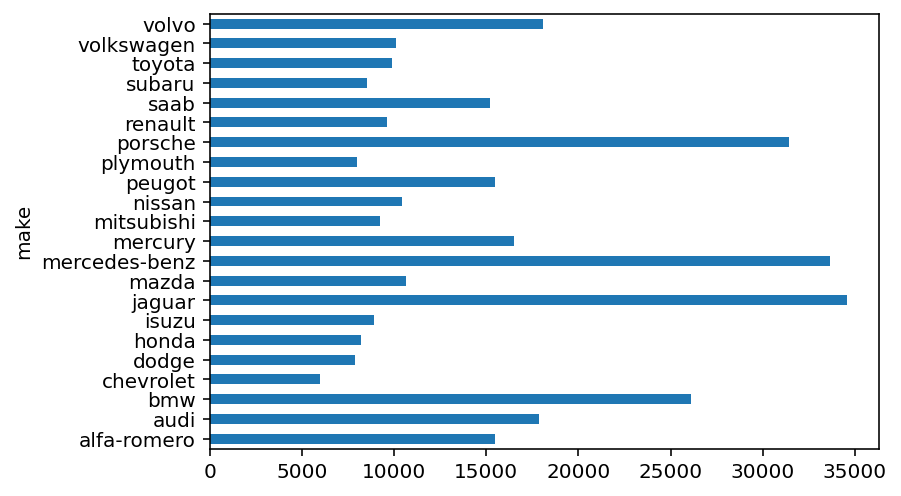

In [224]:
%config InlineBackend.figure_format = 'retina'
df.groupby("make").mean()["price"].plot.barh()

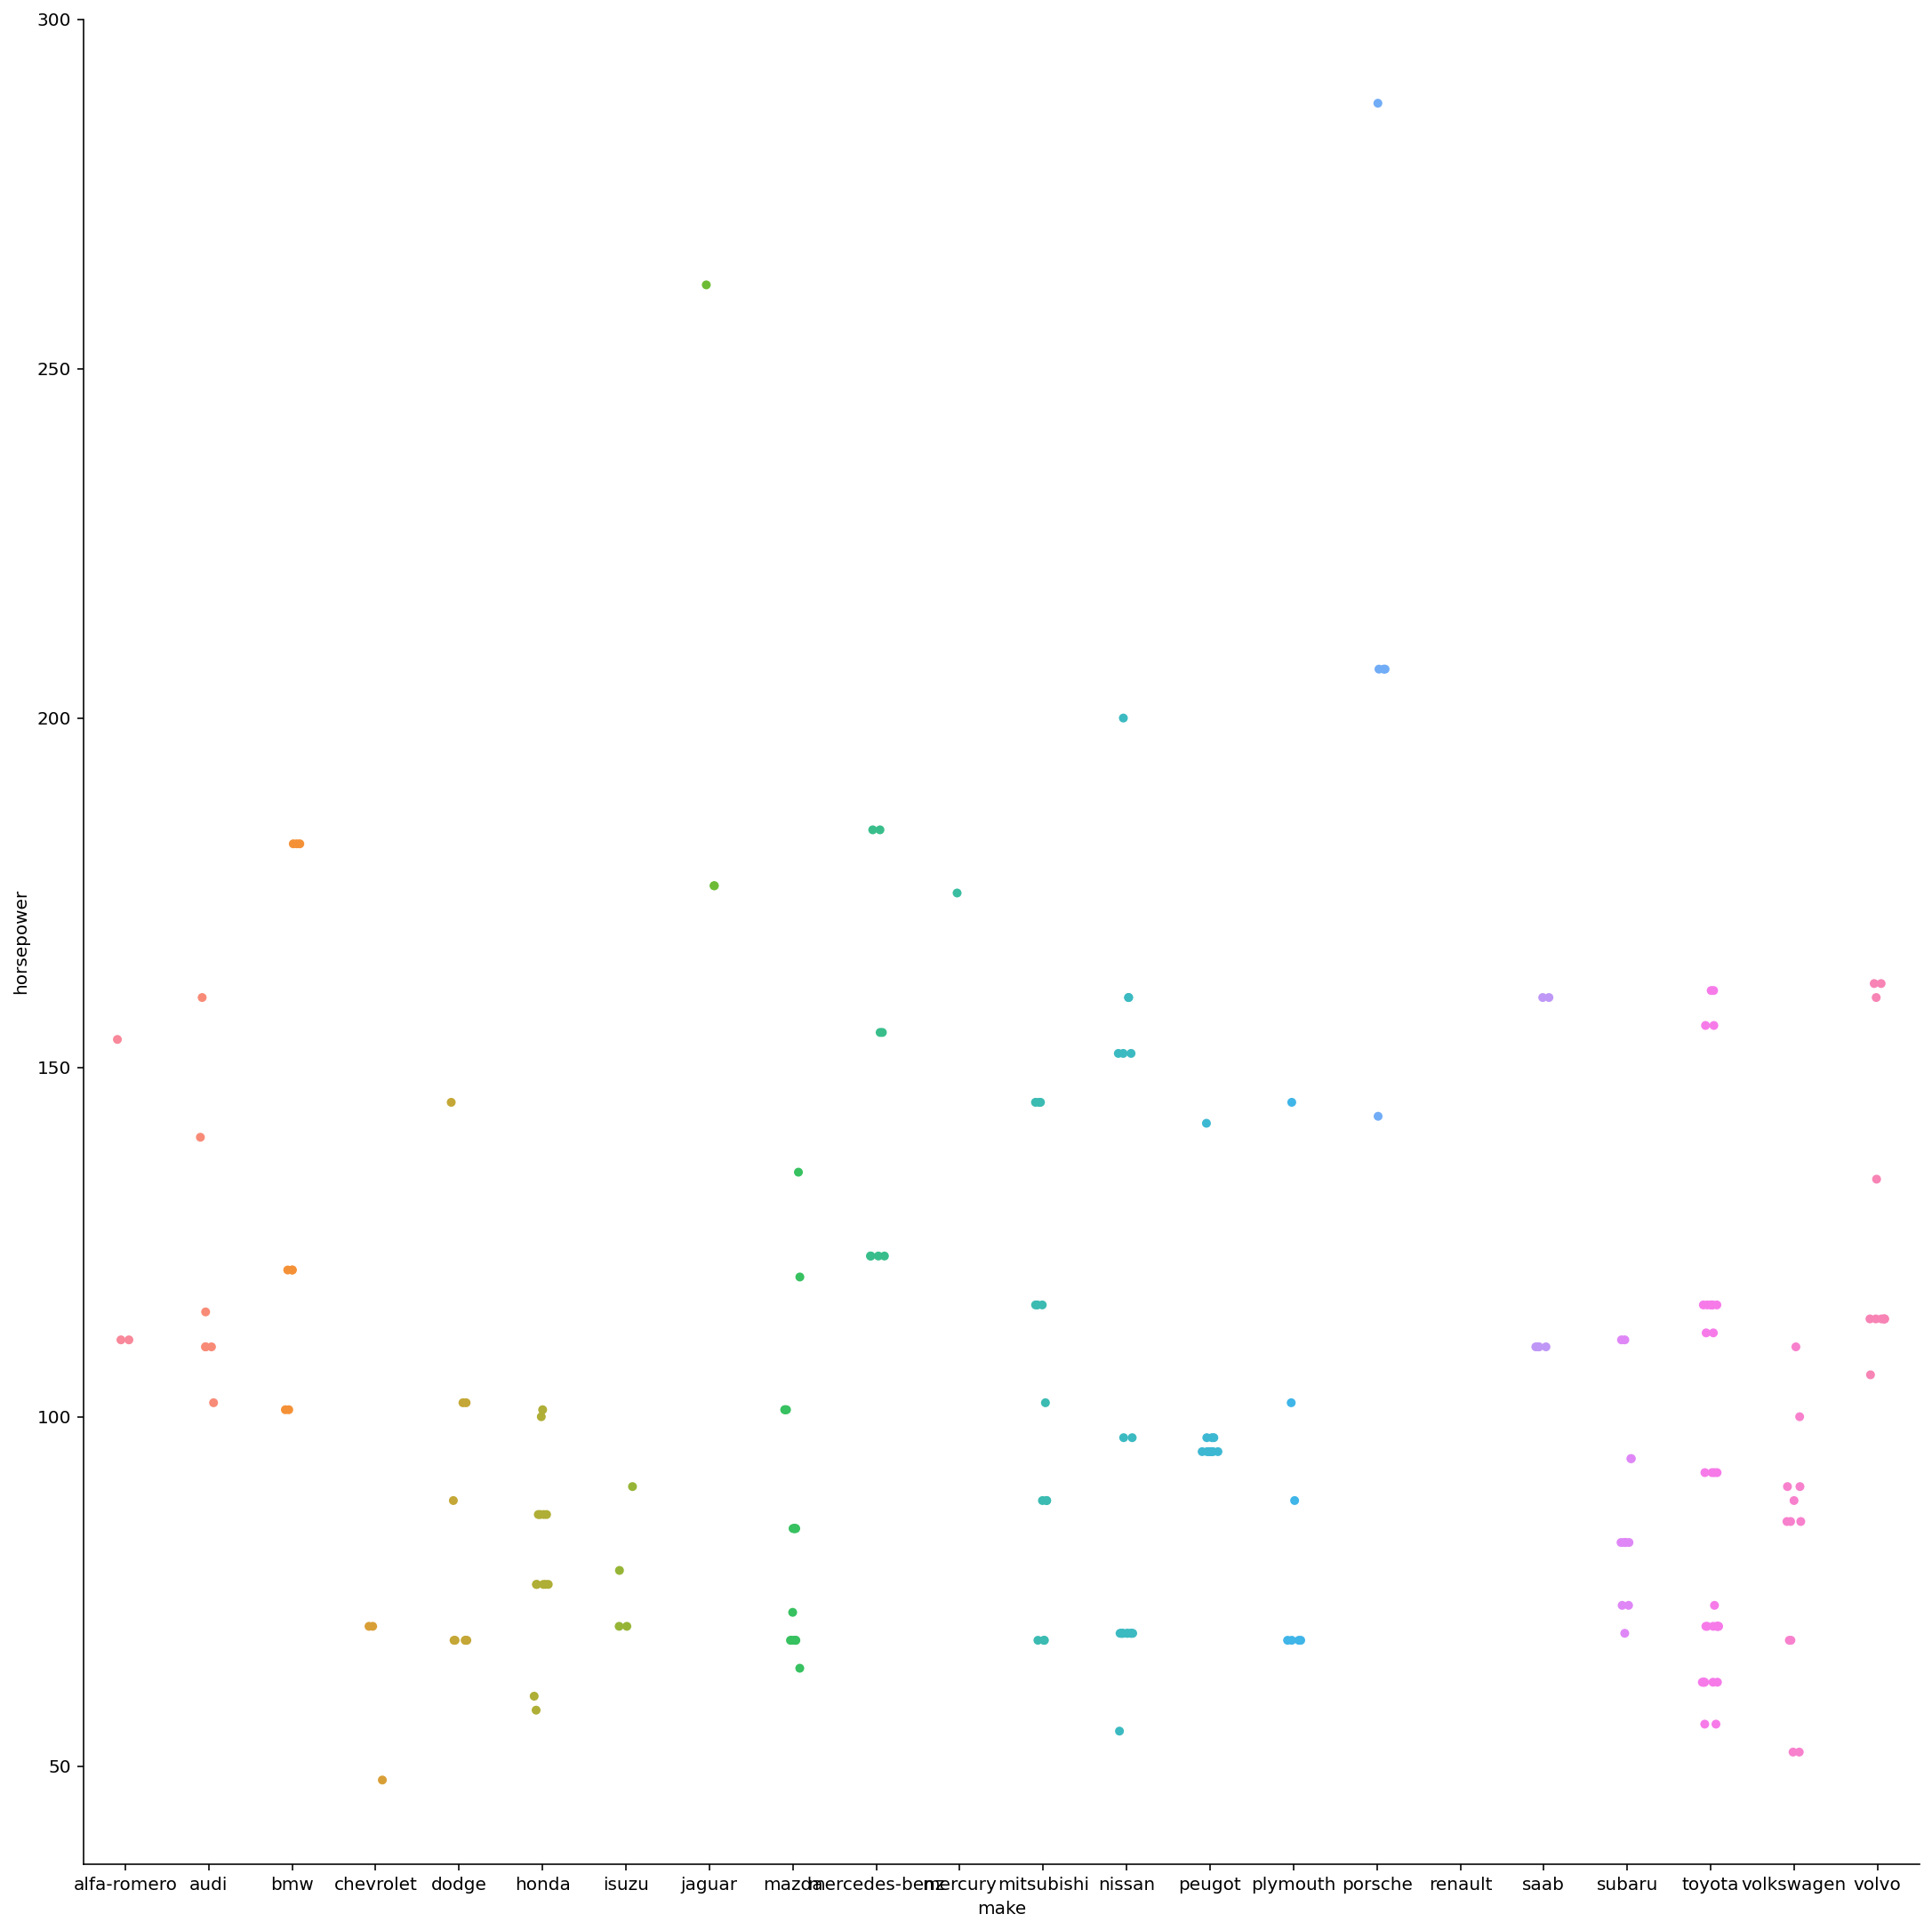

In [225]:
sns.catplot(x = 'make' , y = "horsepower", data = df,height=15); 

In [226]:
df.head()

,symboling,normalized.losses,make,fuel.type,aspiration,num.of.doors,body.style,drive.wheels,engine.location,wheel.base,...,engine.size,fuel.system,bore,stroke,compression.ratio,horsepower,peak.rpm,city.mpg,highway.mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


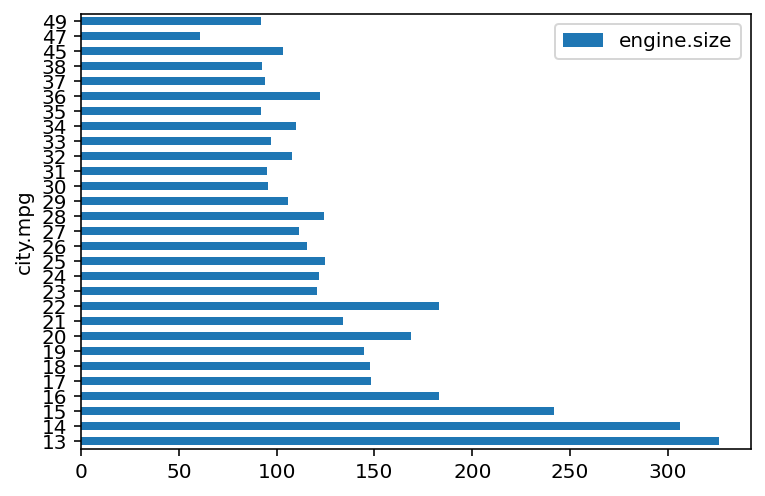

In [229]:
df.groupby("city.mpg").agg({"engine.size":"mean"}).plot.barh();

In [232]:
def power(horsepower):
    if horsepower >=150:
        return "powerful"
    else:
        return "low power"

In [231]:
df["horsepower"].apply(power)

0      low power
1      low power
2       powerful
3      low power
4      low power
         ...    
200    low power
201     powerful
202    low power
203    low power
204    low power
Name: horsepower, Length: 205, dtype: object

In [236]:
import plotly.express as px
fig = px.scatter_matrix(df, dimensions=["horsepower", "price","city.mpg","wheel.base","bore","stroke","engine.size"],height=1300,width=1300)
fig.show()

In [263]:
df = df.fillna(value=0)
df.isnull().sum()

symboling            0
normalized.losses    0
make                 0
fuel.type            0
aspiration           0
num.of.doors         0
body.style           0
drive.wheels         0
engine.location      0
wheel.base           0
length               0
width                0
height               0
curb.weight          0
engine.type          0
num.of.cylinders     0
engine.size          0
fuel.system          0
bore                 0
stroke               0
compression.ratio    0
horsepower           0
peak.rpm             0
city.mpg             0
highway.mpg          0
price                0
dtype: int64

In [268]:
X = df[["width","length","curb.weight","engine.size","horsepower"]]
y = df.price

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30,
                                                          train_size = 0.70, random_state =0)

In [276]:
knn_model = KNeighborsRegressor().fit(X_train, y_train)


In [279]:
from sklearn.metrics import r2_score,mean_squared_error
y_pred = knn_model.predict(X_test)
np.sqrt(mean_squared_error(y_test,y_pred))

4986.151747234696

In [332]:
new_data = [[64.1],[168.8],[2548],[130],[111.0]]
new_data = pd.DataFrame(new_data).T
y_pred1=knn_cv_model.predict(X)


In [333]:
k_t = pd.DataFrame({"Prediction": y_pred1[0:10],
                    "Real_vallue": y[0:10]})
k_t

,Prediction,Real_vallue
0,13495.0,13495.0
1,13495.0,16500.0
2,16500.0,16500.0
3,13950.0,13950.0
4,17710.0,17450.0
5,9639.0,15250.0
6,17710.0,17710.0
7,16845.0,18920.0
8,22625.0,23875.0
9,0.0,0.0


In [316]:
RMSE = []

for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train,y_pred))
    RMSE.append(rmse)
    print("k=",k, "için RMSE value", rmse)

k= 1 için RMSE value 437.8926809162263
k= 2 için RMSE value 2059.6504697866353
k= 3 için RMSE value 2658.36783559754
k= 4 için RMSE value 3010.0088750508057
k= 5 için RMSE value 3290.981139480988
k= 6 için RMSE value 3316.2207764195205
k= 7 için RMSE value 3626.4501468147428
k= 8 için RMSE value 3785.198960224913
k= 9 için RMSE value 3809.8234906791104
k= 10 için RMSE value 3904.452244464094


In [317]:
from sklearn.model_selection import GridSearchCV

In [328]:
knn_params = {"n_neighbors": np.arange(1,30,1)}
knn =KNeighborsRegressor(n_neighbors=1)


In [329]:
knn_cv_model = GridSearchCV(knn,knn_params, cv =10)

In [330]:
knn_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=1, p=2,
                                           weights='uniform'),
             n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [331]:
knn_cv_model.best_params_["n_neighbors"]

1

In [322]:
RMSE = []
RMSE_CV =[]

for k in range(10):
    k = k+1
    knn_model = KNeighborsRegressor(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn_model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train,y_pred))
    rmse_cv = np.sqrt(-1*cross_val_score(knn_model,X_train,y_train,cv=10,
                                        scoring = "neg_mean_squared_error").mean())
    RMSE.append(rmse)
    RMSE_CV.append(rmse_cv)
    print("k=",k, " RMSE value", rmse, "RMSE_CV value:", rmse_cv)

k= 1  RMSE value 437.8926809162263 RMSE_CV value: 4262.601262363718
k= 2  RMSE value 2059.6504697866353 RMSE_CV value: 4116.084009190567
k= 3  RMSE value 2658.36783559754 RMSE_CV value: 4108.72855245729
k= 4  RMSE value 3010.0088750508057 RMSE_CV value: 4141.856002636666
k= 5  RMSE value 3290.981139480988 RMSE_CV value: 4273.232349273345
k= 6  RMSE value 3316.2207764195205 RMSE_CV value: 4323.261914459789
k= 7  RMSE value 3626.4501468147428 RMSE_CV value: 4256.053836056708
k= 8  RMSE value 3785.198960224913 RMSE_CV value: 4360.1512769344345
k= 9  RMSE value 3809.8234906791104 RMSE_CV value: 4429.3873916812645
k= 10  RMSE value 3904.452244464094 RMSE_CV value: 4453.936146611273


In [327]:
knn_tuned = KNeighborsRegressor(n_neighbors = 1)
knn_tuned.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='uniform')

In [326]:
np.sqrt(mean_squared_error(y_test,knn_tuned.predict(X_test)))

4910.533506919655

# Logistic_Regression

In [340]:
from sklearn.linear_model import LogisticRegression
loj = LogisticRegression()
loj_model = loj.fit(X_train,y_train)
#loj_model.coef_

In [341]:


y_pred = loj_model.predict(X)



In [342]:
accuracy_score(y,y_pred)

0.36097560975609755

# Random Forest

In [348]:
from sklearn.ensemble import RandomForestRegressor

In [350]:
forest = RandomForestRegressor(n_estimators= 100,
                            criterion= "mse",
                            random_state= 1,
                            n_jobs= -1)

forest.fit(X_train,y_train)
forest_train_pred = forest.predict(X_train)
forest_test_pred = forest.predict(X_test)
print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train,forest_train_pred),
mean_squared_error(y_test,forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))

MSE train data: 1094477.856, MSE test data: 30411382.140
R2 train data: 0.983, R2 test data: 0.552


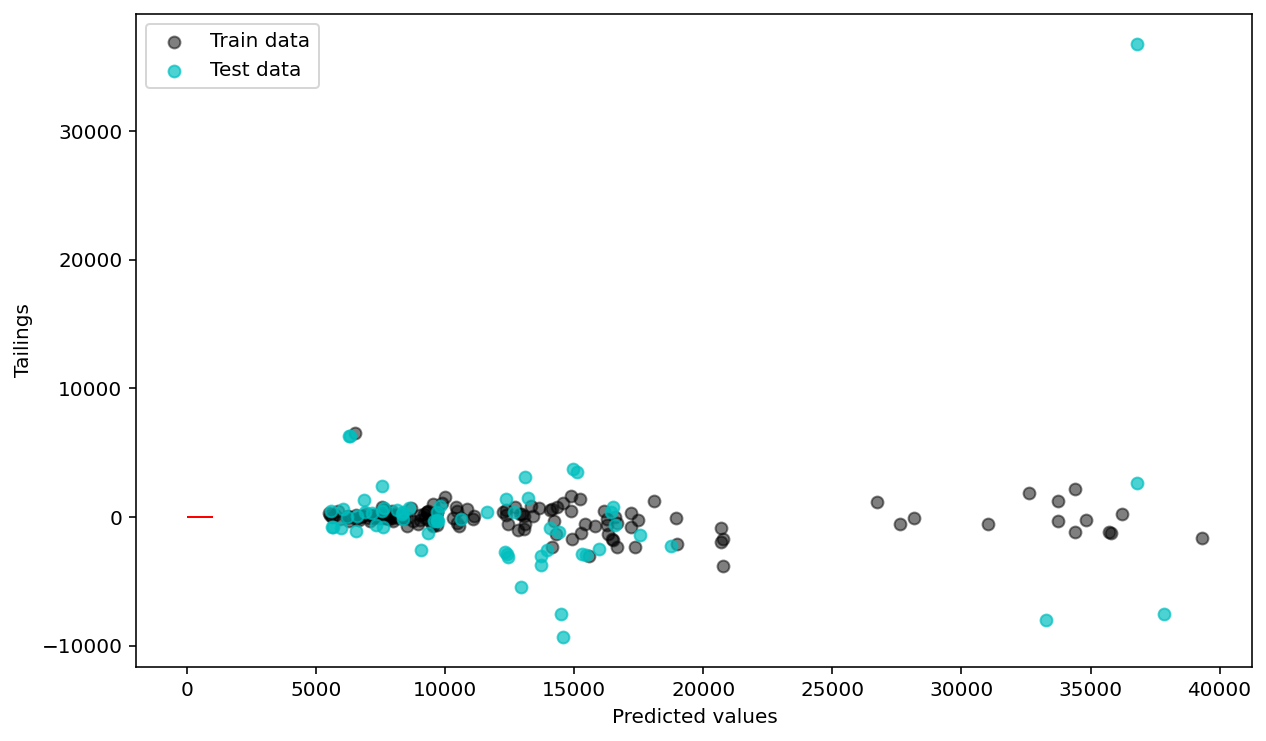

In [351]:
import matplotlib.pyplot as pl

pl.figure(figsize=(10,6))

pl.scatter(forest_train_pred,forest_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
pl.scatter(forest_test_pred,forest_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.legend(loc = 'upper left')
pl.hlines(y = 0, xmin = 0, xmax = 1000, lw = 1, color = 'red')
pl.show()

In [392]:
new_data = [[64.1],[168.8],[2548],[130],[111.0]]
new_data = pd.DataFrame(new_data).T
y_pred1=forest.predict(new_data)
y_pred1

array([14152.215])

In [353]:
k_t = pd.DataFrame({"Prediction": y_pred1[0:10],
                    "Real_vallue": y[0:10]})
k_t

,Prediction,Real_vallue
0,14152.215,13495.0
1,14152.215,16500.0
2,15247.000,16500.0
3,13056.125,13950.0
4,13715.095,17450.0
5,12385.705,15250.0
6,17451.700,17710.0
7,17563.200,18920.0
8,14557.090,23875.0
9,6522.090,0.0


In [390]:
forest.score(X_train,y_train)

0.9827611573188962

In [393]:
np.sqrt(mean_squared_error(y_test,forest.predict(X_test)))

5514.651588302404

# PY CARET

In [380]:
from pycaret.classification import *
from pycaret.datasets import get_data
diabetes = get_data('diabetes')

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [389]:
from pycaret.datasets import get_data

juice = get_data('juice')

from pycaret.classification import *

exp_name = setup(data = juice,  target = 'Purchase')

best_model = compare_models()

,Id,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:47:55
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies


ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

,Description,Value
0,session_id,7064
1,Target,price
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(205, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [379]:
compare_models()

[]

IndexError: pop from empty list